# NPZD parameter estimation prototype

 * using a differential evolution (DE) algorithm

### model code (all contained in box 1)

In [1]:
import numpy as np

# parameter values
parameters = {
    'vmax': 0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat': 0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz': 0.02,        # zooplankton grazing rate
    'mortP': 0.02,       # phytoplankton mortality rate
    'mortZ': 0.03,       # zooplankton mortality rate
    'reminrate': 0.1,    # remineralization rate
}

# model 
def npzd(x, t, parameters, light):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    '''
    n, p, z, d = np.maximum(x, 0.0)
    
    growth = parameters['vmax'] * n / (parameters['nuthalfsat'] + n) * light(t) * p
    grazing = parameters['graz'] * p * z
    p_loss = parameters['mortP'] * p
    z_loss = parameters['mortZ'] * z * z
    remin = parameters['reminrate'] * d
    
    return np.array((-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin))

### code to run model (some or all contained in box 1)

In [2]:
from scipy.integrate import odeint

# initial conditions
x0 = np.array((0.6, 0.15, 0.2, 0.05))

# initialize time vector (1 year)
t = np.arange(0.0, 2 * 365.0, 1.0)

# light function returning irradiance at time t
def light(t):
    return 1.0 + 0.5*(0.8 * np.sin(np.pi*((t-81.25)/182.5)) - 0.8)

def run_model(parameter_changes=None):
    parameters_run = parameters.copy()
    if parameter_changes is not None:
        parameters_run.update(parameter_changes)
    return odeint(npzd, x0, t, args=(parameters_run, light))

### settings changeable by the user

Parameters not listed in `parameters_reference` are assumed to be constant and kept at the values specified in `parameters` the top of the notebook. Currently, the values in `parameters` for parameters that are being estimated, are the mean values for the prior ensemble. 

In [3]:
# select which parameters to estimate and what their reference or "true" values should be
parameters_reference = {
    'vmax': 0.06,
    'reminrate': 0.12,
}

# select when to observe state
t_obs = 70 # day 70 (compare plot in NPZD notebook)

# select which state variables to observe
i_obs = np.array([0, 1, 2]) # N, P, Z

# select the observation uncertainty
obs_uncertainty = np.array([0.0003, 0.0003, 0.0003])

# select population size
n_pop = 50

n_parent = n_pop // 2

n_gen = 10

# select the standard deviation of the prior ensemble for each paramete
prior_uncertainty = np.array([0.01, 0.03])

### code to generate synthetic data and create the ensembles

In [4]:
n_par = len(parameters_reference)
n_obs = len(i_obs)

# use model to generate the synthetic data
obs = run_model(parameter_changes=parameters_reference)[t_obs, i_obs]

# generate ensemble of observations
y = obs[:,None] # + obs_uncertainty * np.random.normal(size=n_obs) ################### TODO

# generate the prior ensemble of parameters
pop_mean = np.array([parameters[p] for p in parameters_reference.keys()])
pop = np.maximum(0.0, pop_mean[:,None] + prior_uncertainty[:,None] * np.random.normal(size=(n_par, n_pop)))
assert not np.any(np.isnan(pop)), 'Pop trouble'.format(igen)

# keep a copy
pop_initial = pop.copy()

# not in-place
def compute_fitness(pop):
    fitness = np.empty(pop.shape[1])
    for ipop, params in enumerate(pop.T):
        parameter_changes = {p: v for p, v in zip(parameters_reference.keys(), pop[:, ipop])}
        x = run_model(parameter_changes=parameter_changes)[t_obs, i_obs]
        fitness[ipop] = np.sum((obs_uncertainty / (x - y))**2)
    return fitness

# in-place
def recombine(parents, n_child):
    n_parent = parents.shape[1]
    children = np.empty((parents.shape[0], n_child))
    for ichild in range(n_child):
        i0 = np.random.randint(0, n_parent)
        i1 = np.random.randint(0, n_parent-1)
        i2 = np.random.randint(0, n_parent-2)
        
        i1 += (i1 >= i0)
        i2 += (i2 >= i0)
        i2 += (i2 >= i1)
        
        children[:, ichild] = np.maximum(0.0, parents[:, i0] + (parents[:, i1] - parents[:, i2]))
        
    return children

### code to perform differential evolution

In [5]:
fitness = compute_fitness(pop)
n_child = n_pop - n_parent

indi_highest_fitness = np.empty((pop.shape[0], n_gen + 1))

for igen in range(n_gen):
    index = np.argsort(fitness)
    
    indi_highest_fitness[:, igen] = pop[:, index[-1]]
    
    print(igen, fitness[index[::-1]][:5])
    index_child = index[:n_child]
    index_parent = index[n_child:]
    assert not np.any(np.isnan(pop)), 'Pop trouble igen={}, before'.format(igen)
    pop[:,index_child] = recombine(parents=pop[:,index_parent], n_child=n_child)
    assert not np.any(np.isnan(pop)), 'Pop trouble igen={}, after'.format(igen)
    
    fitness[index_child] = compute_fitness(pop[:,index_child])
    
index = np.argsort(fitness)
indi_highest_fitness[:, -1] = pop[:, index[-1]]

0 [10.52213092  9.82682683  4.80250455  0.72339221  0.70658034]
1 [5.85798496e+03 1.05221309e+01 9.82682683e+00 6.08699878e+00
 4.80250455e+00]
2 [5857.98495761   58.52349232   17.62144423   15.34149565   10.52213092]
3 [5857.98495761   58.52349232   53.52468434   17.62144423   15.34149565]
4 [5857.98495761  507.92126878  262.5379132   101.6425119    58.52349232]
5 [5857.98495761  553.63672094  507.92126878  262.5379132   237.35012909]
6 [33574.19942378  5857.98495761   553.63672094   507.92126878
   262.5379132 ]
7 [33574.19942378 30243.78393681  5857.98495761   553.63672094
   507.92126878]
8 [190409.60995942  33574.19942378  30243.78393681  14774.83243326
   5857.98495761]
9 [190409.60995942  33574.19942378  30243.78393681  14774.83243326
   5857.98495761]


### prepare plotting

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 20

### plotting

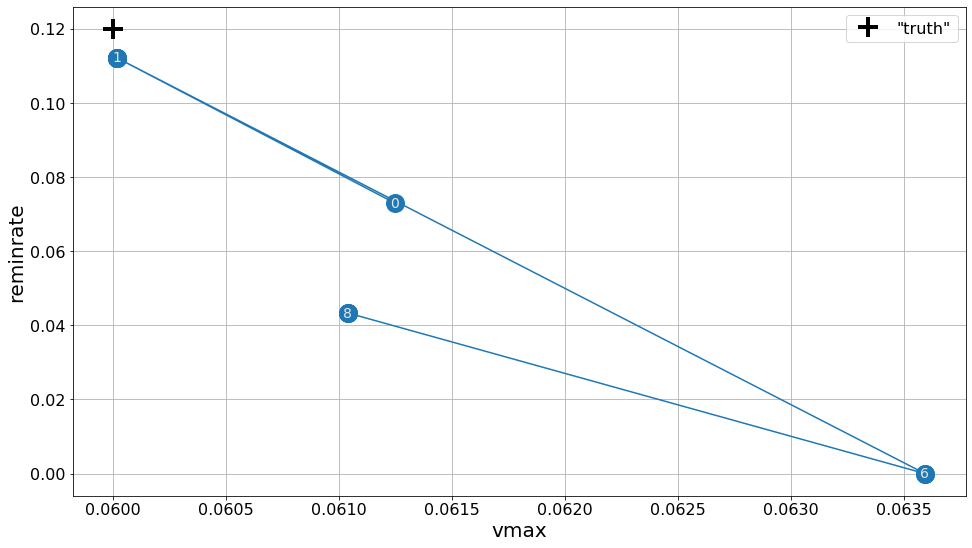

In [7]:
fig, ax = plt.subplots()

ref = np.array([v for v in parameters_reference.values()])
ax.plot(ref[0], ref[1], ls='none', marker='+', mew=4, color='black', ms=20, label='"truth"')
#ax.axvline(ref[0], color='black')
#ax.axhline(ref[1], color='black')

# colors = ('#228833', '#4477AA', '#EE6677', '#CCBB44') # colorblind-friendly colors

#draw_ensemble(ax, pop_initial, color='#EE6677', label='prior')
#draw_ensemble(ax, pop, color='#4477AA', label='posterior')

ax.plot(indi_highest_fitness[0, :], indi_highest_fitness[1, :], marker='o', ms=19, mec='none')

for igen in range(n_gen + 1):
    if igen == 0 or not np.array_equal(indi_highest_fitness[:, igen], indi_highest_fitness[:, igen-1]):
        ax.text(indi_highest_fitness[0, igen], indi_highest_fitness[1, igen], str(igen), color='0.9', 
                va='center', ha='center', size=14)


parameter_names = list(parameters_reference.keys())
ax.set(xlabel=parameter_names[0], ylabel=parameter_names[1])
ax.legend()
ax.grid(True)
None